In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import torch.optim as optim

from load_datasets import load_datasets
from torch.utils.data import DataLoader
from utils import *
# from model import *
from model import *
from save_obj import *
import pickle as pkl
from TorchCoder import *

In [3]:
import easydict

args = easydict.EasyDict({
    'path':'./dataset/test/',
    'mode':'train',
    'pretrained_mode':False,
    'time_limited':5,
    'down_sampling':False,
    'down_sampling_rate':16000,
    'n_mfcc':64,
    'windows':5,
    'hidden_size':128,
    'num_layers':2,
    'batch_size':64,
    'epoch':1000,
    'pretrained_model':'./model.pt'
})


In [4]:
datasets = load_datasets(args)

[+] get train data 	(1.784 sec)


In [5]:
data_loader = DataLoader(
        datasets, 
        batch_size=32, 
        shuffle=False
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[+] {device} is available")

[+] cpu is available


In [5]:
model = AutoEncoderLSTM(
    sequence_length=datasets.size(1),
    in_size=datasets.size(2),
    hidden_size=args.hidden_size,
    num_layers=args.num_layers,
    device=device
).to(device=device)

In [6]:
criterion = nn.MSELoss(reduction='mean')
model = load_model(args, model)
context_vector = load_object(args, 'context_vector')
model.eval()

[+] model load mode [complete]
[+] object load mode [complete]


AutoEncoderLSTM(
  (encoder): Encoder(
    (rnn): LSTM(128, 128, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): LSTM(128, 256, num_layers=2, batch_first=True)
    (fc1): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [7]:
result = []
for data in data_loader:
    inputs = data
    inputs = inputs.to(device=device)     

    encoded, decoded = model(inputs)
    result.append((data, decoded))

In [8]:
result

[(tensor([[[1.7721e+00, 6.9926e-01, 3.3953e-01,  ..., 6.1880e-05,
            2.0313e-05, 2.7964e-06],
           [2.4477e+00, 2.2342e+00, 6.5550e-01,  ..., 1.2094e-04,
            3.9317e-05, 3.4647e-06],
           [4.8833e+00, 2.1848e+00, 6.7825e-01,  ..., 1.4313e-04,
            3.9512e-05, 3.9205e-06],
           ...,
           [5.5870e+00, 1.0065e+00, 7.2509e-01,  ..., 1.4363e-04,
            4.6498e-05, 4.6694e-06],
           [5.6573e+00, 2.3447e+00, 4.5650e-01,  ..., 1.5265e-04,
            4.6229e-05, 1.3138e-05],
           [2.4167e+00, 2.3077e+00, 5.9415e-01,  ..., 8.0339e-05,
            2.9175e-05, 3.3282e-05]]]),
  tensor([[[ 2.0198,  1.0294,  0.8931,  ...,  0.0548, -0.1620,  0.0127],
           [ 4.6831,  2.0125,  1.0693,  ...,  0.0613, -0.3525,  0.0413],
           [ 4.8536,  2.0219,  1.7968,  ..., -0.0135, -0.2770,  0.0435],
           ...,
           [ 3.4366,  1.1501,  3.6472,  ...,  0.0350, -0.0497, -0.0354],
           [ 3.4366,  1.1500,  3.6473,  ...,  0.0350, -

In [9]:
inputs, decoded = result[0]

In [10]:
criterion(inputs.to(device), decoded)

tensor(71.4820, device='cuda:0', grad_fn=<MseLossBackward>)

In [11]:
print(f'inputs shape : {inputs.shape}')
print(f'decoded shape : {decoded.shape}')

inputs shape : torch.Size([1, 216, 128])
decoded shape : torch.Size([1, 216, 128])


In [12]:
inputs = inputs.squeeze()
decoded = decoded.squeeze()

inputs = torch.transpose(inputs, 1, 0)
decoded = torch.transpose(decoded, 1, 0)

In [13]:
print(f'inputs shape : {inputs.shape}')
print(f'decoded shape : {decoded.shape}')

inputs shape : torch.Size([128, 216])
decoded shape : torch.Size([128, 216])


In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [17]:
inputs_arr = inputs.cpu().detach().numpy()
decoded_arr = decoded.cpu().detach().numpy()

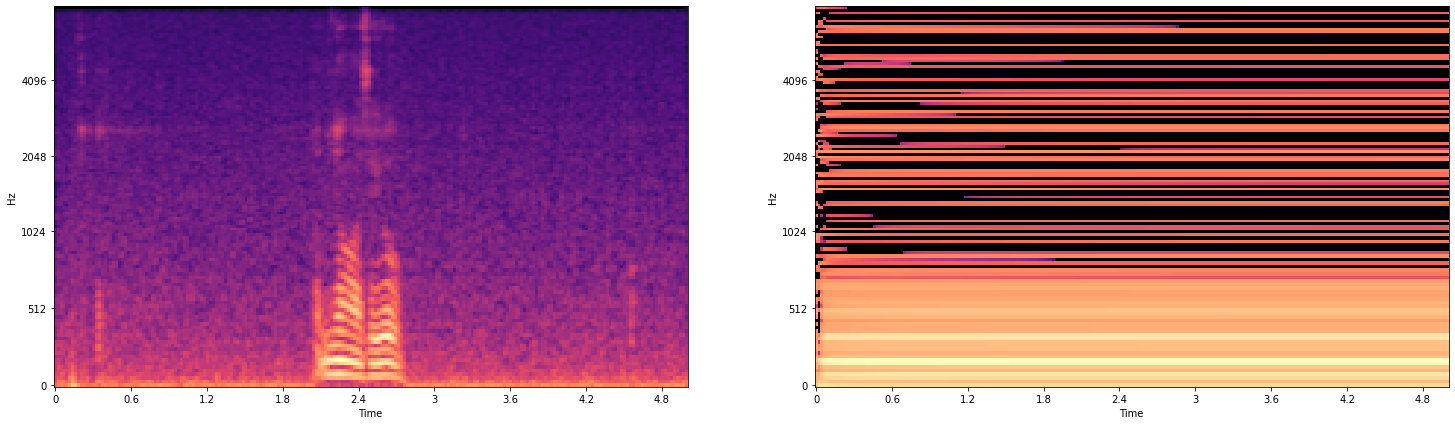

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(25, 7))


S_dB = librosa.power_to_db(inputs_arr, ref=np.max)
librosa.display.specshow(
    S_dB, 
    x_axis='time',
    y_axis='mel', 
    fmax=8000, 
    ax=ax[0]
)

S_dB = librosa.power_to_db(decoded_arr, ref=np.max)
librosa.display.specshow(
    S_dB, 
    x_axis='time',
    y_axis='mel', 
    fmax=8000, 
    ax=ax[1]
)